In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib


In [3]:
# !unzip Dataset_4_classes.zip

In [4]:
ds_path = 'Dataset_4_classes'

In [5]:
data_dir = pathlib.Path(ds_path)

In [6]:
len(list(data_dir.glob('*/*.JPG')))

4590

In [7]:
os.listdir(data_dir)

['Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Leaf_Mold',
 'Tomato___Tomato_mosaic_virus']

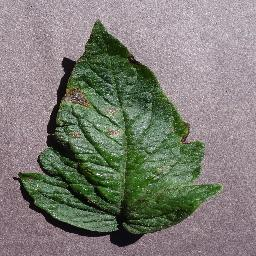

In [8]:
tbs = list(data_dir.glob('Tomato___Early_blight/*'))
PIL.Image.open(str(tbs[0]))

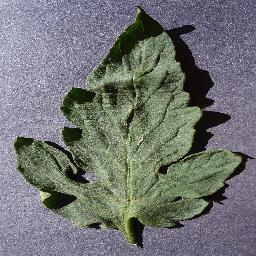

In [9]:
teb = list(data_dir.glob('Tomato___healthy/*'))
PIL.Image.open(str(teb[0]))

In [10]:
batch_size = 1
img_height = 256
img_width = 256

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.01,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
#   label_mode = 'int',
  batch_size=batch_size)

Found 4591 files belonging to 4 classes.
Using 4546 files for training.


In [12]:
# val_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(img_height, img_width),
# #   label_mode = 'int',
#   batch_size=batch_size)

In [13]:
class_names = train_ds.class_names
print(class_names)

['Tomato___Early_blight', 'Tomato___Leaf_Mold', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [14]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [15]:
# for image_batch, labels_batch in train_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
len(train_ds)

4546

In [20]:
images = []
lables = []
# img1, img2, img3, img4, img5 = [], [], [], [], []
for image, label in train_ds:
#     images.append('1')
    if len(images) == 0:
        images = tfds.as_numpy(image)
        labels = label #label.as_numpy(label)
    elif len(images):
        images = np.append(images, tfds.as_numpy(image), axis=0)
        labels = np.append(labels, tfds.as_numpy(label), axis=0)

In [21]:
print(len(images))
# print(images[0])
print(len(labels))

4546
4546


In [22]:
with open('input_images_4_classes.npy', 'wb') as image_array_file:
    np.save(image_array_file, images)
with open('input_images_4_labels.npy', 'wb') as label_array_file:
    np.save(label_array_file, labels)

In [20]:
with open('input_images_4_classes.npy', 'rb') as image_array_file:
    input_images = np.load(image_array_file)
with open('input_images_4_labels.npy', 'rb') as label_array_file:
    input_labels = np.load(label_array_file)
    
    
# input_images = images
# input_labels = lables
print(len(input_images))
print(len(input_labels))

4546
4546


In [24]:
# for image, label in val_ds:
# #     print(image.numpy)
#     print(len(label))
#     break

### Data input using imread

In [25]:
# import imageio

In [26]:
# categories = os.listdir(ds_path)
# print(categories)

In [27]:
# #create t1 dataset
# images = []
# image_names = os.listdir(ds_path+'/'+categories[0])
# for image_name in image_names:
#     image = imageio.imread(ds_path+'/'+categories[0]+'/'+image_name)
#     images.append(image)
# t1_dataset = np.asarray(images)

In [28]:
# t1_dataset.shape

In [29]:
# #visualize an image belonging to t1 dataset
# plt.figure(figsize=(2,2))
# plt.imshow(t1_dataset[1], cmap='gray')
# plt.axis('off')
# plt.show()

# C-GAN

In [21]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
# from keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

from matplotlib import pyplot as plt

In [22]:
#############################################################################
#Define generator, discriminator, gan and other helper functions
#We will use functional way of defining model as we have multiple inputs; 
#both images and corresponding labels. 
########################################################################

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid act56vation.

#Unlike regular GAN here we are also providing number of classes as input. 
#Input to the model will be both images and labels. 
def define_discriminator(in_shape=(256,256,3), n_classes=4):
	
    # label input
	in_label = Input(shape=(1,))  #Shape 1
	# embedding for categorical input
    #each label, will be represented by a vector of size 50. 
    #This vector of size 50 will be learnt by the discriminator
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024. 
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1
    
    
	# image input
	in_image = Input(shape=in_shape) #32x32x3
	# concat label as a channel
	merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)
    
	# downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model. 
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1
    
	# define model
    ##Combine input label with input image and supply as inputs to the model. 
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [23]:
test_discr = define_discriminator()
print(test_discr.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        200         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 65536)     3342336     ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                            

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


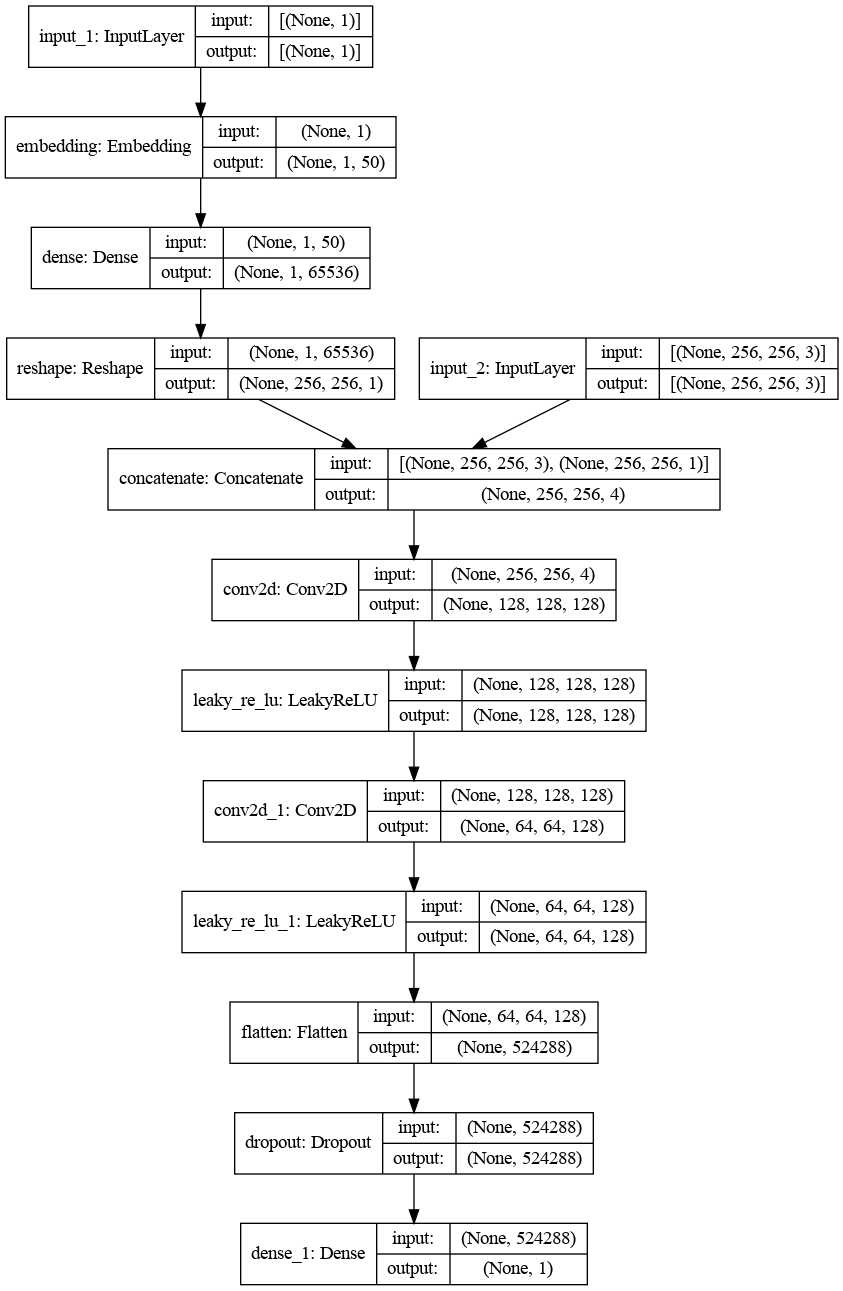

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(test_discr, to_file='discr.png', show_shapes=True, show_layer_names=True)

In [22]:
# define the standalone generator model
#latent vector and label as inputs

def define_generator(latent_dim, n_classes=4):
    
	# label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
    #each label, will be represented by a vector of size 50. 
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
    
	# linear multiplication
	n_nodes = 64 * 64  # To match the dimensions for concatenation later in this step.  
	li = Dense(n_nodes)(li) #1,64
	# reshape to additional channel
	li = Reshape((64, 64, 1))(li)
    
    
	# image generator input
	in_lat = Input(shape=(latent_dim,))  #Input of dimension 100
    
	# foundation for 8x8 image
    # We will reshape input latent vector into 8x8 image as a starting point. 
    #So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
    #it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.
    #Note that this part is same as unconditional GAN until the output layer. 
    #While defining model inputs we will combine input label and the latent input.
	n_nodes = 128 * 64 * 64
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((64, 64, 128))(gen) #Shape=8x8x128
	# merge image gen and label input
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model   #Model not compiled as it is not directly trained like the discriminator.

In [23]:
test_gen = define_generator(100, n_classes=4)
print(test_gen.summary())

2022-11-29 10:29:18.568825: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 209715200 exceeds 10% of free system memory.
2022-11-29 10:29:18.651509: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 209715200 exceeds 10% of free system memory.
2022-11-29 10:29:18.710016: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 209715200 exceeds 10% of free system memory.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 524288)       52953088    input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        200         input_3[0][0]                    
____________________________________________________________________________________________

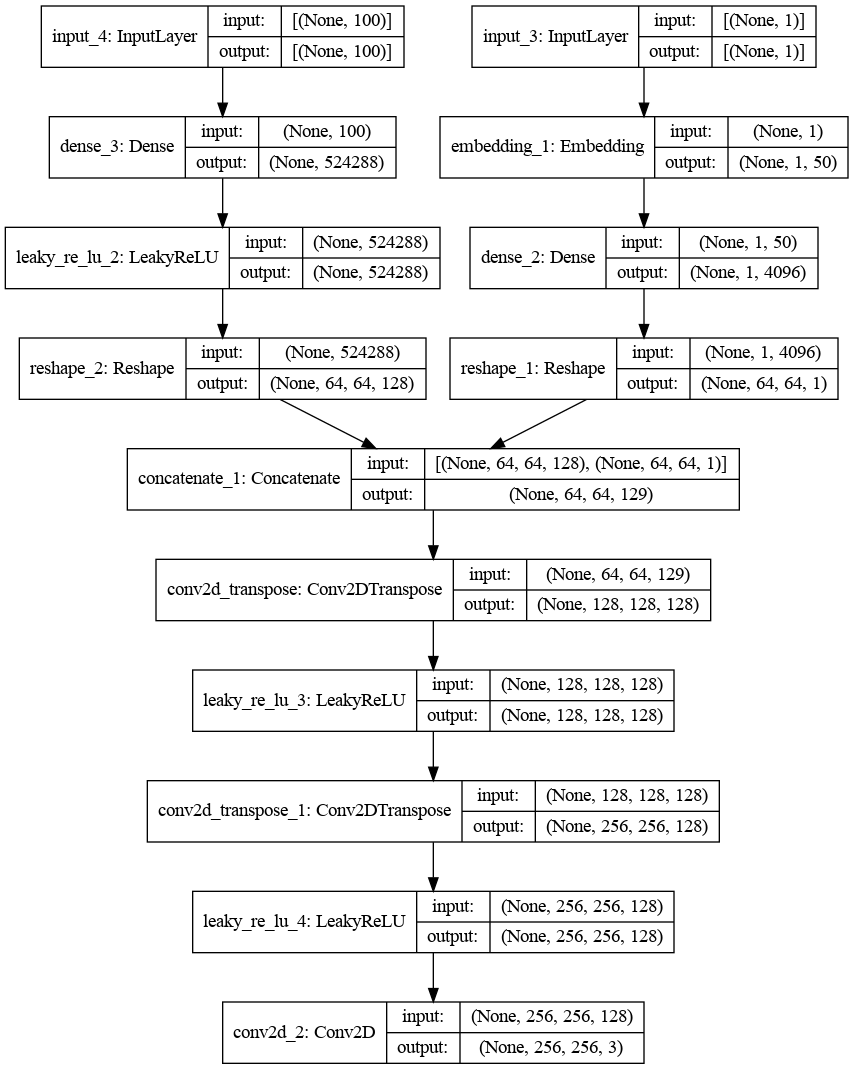

In [24]:
from keras.utils.vis_utils import plot_model
plot_model(test_gen, to_file='generator.png', show_shapes=True, show_layer_names=True)

In [26]:
# #Generator is trained via GAN combined model. 
# define the combined generator and discriminator model, for updating the generator
#Discriminator is trained separately so here only generator will be trained by keeping
#the discriminator constant. 
def define_gan(g_model, d_model):
	d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.
    
    ## connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  #32x32x3
    
	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [27]:
# load images
def load_real_samples():
	# load dataset
# 	(trainX, trainy), (_, _) = load_data()  
    trainX = input_images
    trainy = input_labels
# convert to floats and scale
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5   #Generator uses tanh activation so rescale 
                #original images to -1 to 1 to match the output of generator.
    return [X, trainy]

# # select real samples
# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another 
#half batch of fake images. 
#For each real image we assign a label 1 and for fake we assign label 0. 
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset  
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (different from input class labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=4):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points. 
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

# train the generator and discriminator
#We loop through a number of epochs to train our Discriminator by first selecting
#a random batch of images from our true/real dataset.
#Then, generating a set of images using the generator. 
#Feed both set of images into the Discriminator. 
#Finally, set the loss parameters for both the real and fake images, as well as the combined loss. 
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			
             # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
            # get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)	
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
             # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Print losses on this batch
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('tomato_4_class_1000_epoch.h5')

In [10]:
#Train the GAN

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000)

2022-11-13 11:16:19.681609: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-13 11:16:19.951517: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400
2022-11-13 11:17:03.497196: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


Epoch>1, Batch1/35, d1=0.725, d2=0.702 g=0.693
Epoch>1, Batch2/35, d1=0.075, d2=0.706 g=0.697
Epoch>1, Batch3/35, d1=0.021, d2=0.704 g=0.713
Epoch>1, Batch4/35, d1=0.009, d2=0.678 g=0.768
Epoch>1, Batch5/35, d1=0.007, d2=0.622 g=0.865
Epoch>1, Batch6/35, d1=0.006, d2=0.564 g=0.966
Epoch>1, Batch7/35, d1=0.006, d2=0.520 g=1.053
Epoch>1, Batch8/35, d1=0.006, d2=0.478 g=1.153
Epoch>1, Batch9/35, d1=0.017, d2=0.467 g=1.232
Epoch>1, Batch10/35, d1=0.013, d2=0.479 g=1.337
Epoch>1, Batch11/35, d1=0.006, d2=0.458 g=1.633
Epoch>1, Batch12/35, d1=0.017, d2=0.271 g=2.380
Epoch>1, Batch13/35, d1=0.005, d2=0.085 g=3.362
Epoch>1, Batch14/35, d1=0.021, d2=0.055 g=3.497
Epoch>1, Batch15/35, d1=0.006, d2=0.058 g=3.374
Epoch>1, Batch16/35, d1=0.004, d2=0.065 g=3.348
Epoch>1, Batch17/35, d1=0.006, d2=0.079 g=3.401
Epoch>1, Batch18/35, d1=0.001, d2=0.073 g=3.601
Epoch>1, Batch19/35, d1=0.004, d2=0.065 g=3.913
Epoch>1, Batch20/35, d1=0.004, d2=0.056 g=4.172
Epoch>1, Batch21/35, d1=0.004, d2=0.069 g=4.703
E

2022-11-16 14:34:07.421585: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 209715200 exceeds 10% of free system memory.
2022-11-16 14:34:24.556166: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3145728000 exceeds 10% of free system memory.


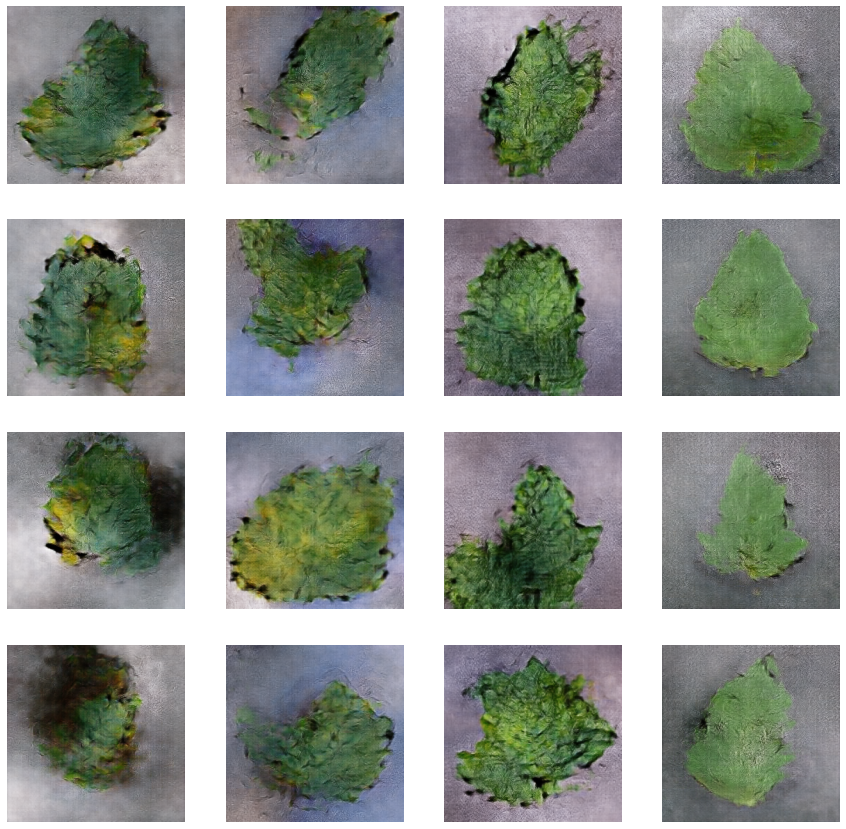

In [46]:
##########################################################
# Now, let us load the generator model and generate images
# Lod the trained model and generate a few images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np
# 


# load model

model = load_model('tomato_4_class_1000_epoch.h5', compile=False)

# generate multiple images

latent_points, labels = generate_latent_points(100, 4000)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = asarray([x for _ in range(1000) for x in range(4)])

# print(len(latent_points[0]))
# print('\n\n\n', labels)

# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
# print(X)
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
# plot the result (10 sets of images, all images in a column should be of same class in the plot)
# Plot generated images 
def show_plot(examples, n):
    plt.figure(figsize=(15,15))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
#         plt.figure(figsize=(5,5))
        plt.imshow(examples[i, :, :, :])
    plt.show()
    
show_plot(X, 4)

In [47]:
len(X)

4000

In [48]:
from PIL import Image
for i in range(len(X)):
    img = Image.fromarray(X[i, :, :, :])
    image_class_dir = class_names[i%4] 
    img.save('Generated Images/%s/%d.JPG' % (image_class_dir,i))

In [45]:

# os.mkdir('Generated Images/%s' % class_names[3])

In [50]:
import shutil
shutil.make_archive('Generate_Images_Comp', 'zip', 'Generated Images')

'/home/Generate_Images_Comp.zip'